# Super-blind case study: local context feature

Here is an example of a blind case study in which our hypothesis obtained by performing circuit analysis with transcoders ended up being way off-base. We're including it with our other case studies in the interest of academic transparency, and because we think it might be useful as an instructive tool for understanding how *not* to jump to conclusions when performing circuit analysis.

Do note, however, that this case study was carried out under a harder "ruleset", so to speak. In normal blind case studies, you're not allowed to look at the input tokens in the maximum-activating examples for a given feature. But a super-blind case study goes further: you're not even allowed to look at which MLP0 transcoder features are active on the maximum-activating examples. (The reasoning: MLP0 is somewhat used as an "extended token embedding" in GPT2-small, and as such, looking at which MLP0 features are active can be viewed as revealing too much information about the original input.)

# Setup

In [1]:
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Load model

In [2]:
from sae_training.sparse_autoencoder import SparseAutoencoder

In [3]:
from transformer_lens import HookedTransformer, utils
model = HookedTransformer.from_pretrained('gpt2')

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


## Loading data

In [4]:
# This function was stolen from one of Neel Nanda's exploratory notebooks
# Thanks, Neel!
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [5]:
from datasets import load_dataset
from huggingface_hub import HfApi

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800*2)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

# Load transcoders

In [7]:
transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
sparsities = []
for i in range(12):
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
    sparsities.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Load transcoder 8 feature frequency info

In [11]:
live_features = np.arange(len(sparsities[8]))[utils.to_numpy(sparsities[8] > -4)]

# Super-blind case study: `live_features[400]`

In a blind feature case study, we try to begin by reverse-engineering a transcoder feature without looking at the top-activating examples. We then form a hypothesis about what the transcoder feature is computing, and only after having done so do we look at the top-activating examples to see if our hypothesis is supported. For other examples of blind case studies, see the notebooks `case_study_citations.ipynb` and `case_study_caught.ipynb`.

But this time, we'll play using an even tougher restriction: *no looking at the de-embeddings for computational paths ending in an MLP0 transcoder!* You see, GPT-2 is thought to use MLP0 as an "extended token embedding" -- meaning that many MLP0 transcoder features are single-token. As such, if we see that a certain MLP0 transcoder feature fires on a given token, and then look at the de-embedding of that feature, we'll then be able to have a much better idea what the original token in the prompt was. This gives a lot of information, which is somewhat antithetical to the spirit of blind case studies.

What is acceptable under this harder ruleset, however, is to take the input-independent pullbacks of a later-layer transcoder feature onto the MLP0 transcoder, and then look at the de-embeddings for those features. This way, we're not certain about what MLP0 transcoder is causing the later-layer transcoder feature to fire *on this input* -- but we can still get an idea.

In [217]:
feature_idx = live_features[400]
my_feature = make_sae_feature_vector(transcoders[8], feature_idx, use_encoder=True, token=-1)
print(my_feature)

mlp8tc[479]@-1


In [218]:
# get scores
scores = get_feature_scores(model, transcoders[8], owt_tokens_torch[:128*100], feature_idx, batch_size=128, use_raw_scores=False)
uniform_samples = sample_uniform(scores, num_samples=50)

  0%|          | 0/100 [00:00<?, ?it/s]

In [219]:
uniform_scores, uniform_idxs = uniform_samples[0], uniform_samples[1]
print(uniform_scores)

[ 0.      0.2537  0.5073  0.761   1.015   1.269   1.522   1.775   2.03
  2.283   2.537   2.791   3.045   3.297   3.55    3.805   4.06    4.312
  4.566   4.82    5.074   5.33    5.582   5.836   6.09    6.34    6.598
  6.848   7.1     7.355   7.605   7.86    8.12    8.37    8.62    8.875
  9.14    9.35    9.64    9.89   10.12   10.414  10.664  10.92   11.26
 11.336  11.67   11.93   12.     12.43  ]


In [221]:
threshold = 10
uniform_idxs = uniform_idxs[uniform_scores>threshold]
uniform_scores = uniform_scores[uniform_scores>threshold]
for x in uniform_idxs: print(f'{x[0]}, {x[1]}')

2979, 46
2227, 53
7589, 89
668, 122
3511, 64
6798, 102


## Input 3511, 64

In [225]:
prompt = owt_tokens_torch[3511,: 64+1]
_, cache = model.run_with_cache(prompt)

In [228]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[479]@-1 <- attn8[5]@62: 8.1
Path [0][1]: mlp8tc[479]@-1 <- attn8[4]@62: 4.3
Path [0][2]: mlp8tc[479]@-1 <- attn8[5]@63: 3.7
Path [0][3]: mlp8tc[479]@-1 <- attn7[9]@62: 3.6
Path [0][4]: mlp8tc[479]@-1 <- attn6[11]@57: 3.5
Path [0][5]: mlp8tc[479]@-1 <- attn7[8]@60: 3.0
Path [0][6]: mlp8tc[479]@-1 <- attn7[5]@57: 2.8
Path [0][7]: mlp8tc[479]@-1 <- attn4[3]@60: 2.6
Path [0][8]: mlp8tc[479]@-1 <- attn6[11]@62: 2.6
Path [0][9]: mlp8tc[479]@-1 <- attn4[9]@62: 2.0
Path [0][10]: mlp8tc[479]@-1 <- attn8[5]@57: 2.0
Path [0][11]: mlp8tc[479]@-1 <- attn8[5]@58: 1.9
Path [0][12]: mlp8tc[479]@-1 <- attn3[11]@62: 1.8
Path [0][13]: mlp8tc[479]@-1 <- mlp3tc[18655]@-1: 1.6
Path [0][14]: mlp8tc[479]@-1 <- mlp7tc[4327]@-1: 1.6
--- Paths of size 3 ---
Path [1][0]: mlp8tc[479]@-1 <- attn6[11]@57: 3.5 <- mlp0tc[17715]@57: 0.94
Path [1][1]: mlp8tc[479]@-1 <- attn3[11]@62: 1.8 <- mlp0tc[22324]@62: 0.94
Path [1][2]: mlp8tc[479]@-1 <- attn4[3]@60: 2.6 <- mlp0tc[6597]@6

Lots of mlp0tc features, but we won't look at them. Instead, we'll filter out paths ending in layer0.

In [229]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- attn8[5]@62: 8.1
Path [1]: mlp8tc[479]@-1 <- attn8[4]@62: 4.3
Path [2]: mlp8tc[479]@-1 <- attn8[5]@63: 3.7
Path [3]: mlp8tc[479]@-1 <- attn7[9]@62: 3.6
Path [4]: mlp8tc[479]@-1 <- attn6[11]@57: 3.5
Path [5]: mlp8tc[479]@-1 <- attn7[8]@60: 3.0
Path [6]: mlp8tc[479]@-1 <- attn7[5]@57: 2.8
Path [7]: mlp8tc[479]@-1 <- attn4[3]@60: 2.6
Path [8]: mlp8tc[479]@-1 <- attn6[11]@62: 2.6
Path [9]: mlp8tc[479]@-1 <- attn4[9]@62: 2.0
Path [10]: mlp8tc[479]@-1 <- attn8[5]@57: 2.0
Path [11]: mlp8tc[479]@-1 <- attn8[5]@58: 1.9
Path [12]: mlp8tc[479]@-1 <- attn3[11]@62: 1.8
Path [13]: mlp8tc[479]@-1 <- mlp3tc[18655]@-1: 1.6
Path [14]: mlp8tc[479]@-1 <- mlp7tc[4327]@-1: 1.6
Path [15]: mlp8tc[479]@-1 <- attn8[5]@62: 8.1 <- mlp7tc[10719]@62: 0.72
Path [16]: mlp8tc[479]@-1 <- mlp3tc[18655]@-1: 1.6 <- attn2[4]@62: 0.54
Path [17]: mlp8tc[479]@-1 <- mlp3tc[18655]@-1: 1.6 <- attn3[9]@62: 0.53
Path [18]: mlp8tc[479]@-1 <- attn7[9]@62: 3.6 <- mlp3tc[16112]@62: 0.43
Path [19]: mlp8tc[47

Huh: most of the contributions are coming from the previous tokens.

First, let's look at mlp7tc[10719].

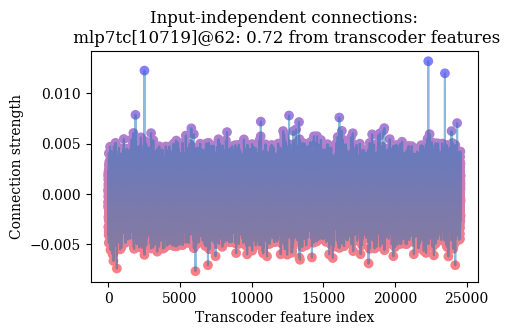

In [230]:
display_transcoder_pullback_features(model, all_paths[15][-1], transcoders[0])

In [231]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 22324, k=5)

In [232]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 2523, k=5)

Okay, "estimated". Next, let's look at

``Path [19]: mlp8tc[479]@-1 <- attn8[5]@58: 1.9 <- attn7[5]@57: 0.39``

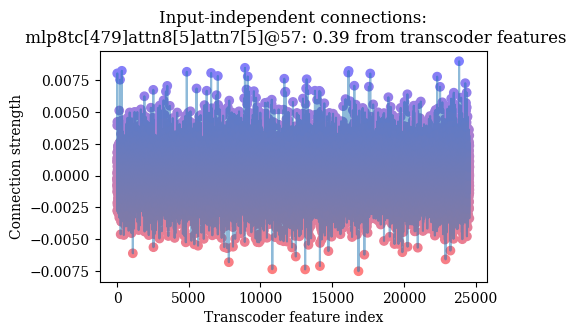

In [233]:
display_transcoder_pullback_features(model, all_paths[19][-1], transcoders[0])

In [234]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 23855, k=5)

In [235]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 8917, k=5)

In [236]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 327, k=5)

Dunno what to make of this. What about `Path [21]: mlp8tc[479]@-1 <- attn8[5]@58: 1.9 <- attn6[11]@57: 0.35`?

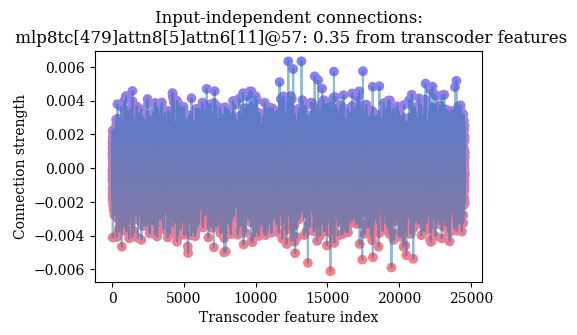

In [237]:
display_transcoder_pullback_features(model, all_paths[21][-1], transcoders[0])

In [239]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 13184, k=2)

In [241]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 12266, k=2)

In [242]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 12610, k=2)

Token 57 has something to do with statistical quantities (" amount", " massive", "total", " comparable", " averaging").

### Final token

Let's now see if we can find anything about the current token that the feature fires on.

In [243]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15, filter=FeatureFilter(token=-1))
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- mlp3tc[18655]@-1: 1.6
Path [1]: mlp8tc[479]@-1 <- mlp7tc[4327]@-1: 1.6
Path [2]: mlp8tc[479]@-1 <- mlp7tc[2901]@-1: 1.2
Path [3]: mlp8tc[479]@-1 <- mlp7tc[13166]@-1: 0.91
Path [4]: mlp8tc[479]@-1 <- mlp7tc[14119]@-1: 0.87
Path [5]: mlp8tc[479]@-1 <- mlp7tc[11293]@-1: 0.6
Path [6]: mlp8tc[479]@-1 <- mlp3tc[1866]@-1: 0.58
Path [7]: mlp8tc[479]@-1 <- mlp7tc[8696]@-1: 0.55
Path [8]: mlp8tc[479]@-1 <- mlp5tc[13393]@-1: 0.55
Path [9]: mlp8tc[479]@-1 <- mlp7tc[21491]@-1: 0.44
Path [10]: mlp8tc[479]@-1 <- mlp7tc[3373]@-1: 0.43
Path [11]: mlp8tc[479]@-1 <- mlp6tc[7080]@-1: 0.41
Path [12]: mlp8tc[479]@-1 <- mlp3tc[2745]@-1: 0.4
Path [13]: mlp8tc[479]@-1 <- mlp7tc[14110]@-1: 0.39
Path [14]: mlp8tc[479]@-1 <- mlp7tc[2901]@-1: 1.2 <- mlp3tc[18655]@-1: 0.24
Path [15]: mlp8tc[479]@-1 <- mlp3tc[18655]@-1: 1.6 <- mlp1tc[20441]@-1: 0.22
Path [16]: mlp8tc[479]@-1 <- mlp3tc[18655]@-1: 1.6 <- mlp2tc[16571]@-1: 0.16
Path [17]: mlp8tc[479]@-1 <- mlp7tc[14110]@-1: 0.39 <- mlp3tc[18

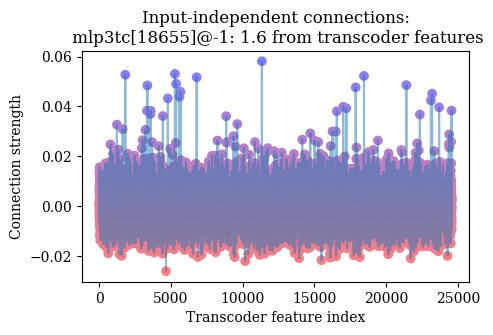

In [244]:
display_transcoder_pullback_features(model, all_paths[0][-1], transcoders[0])

In [245]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 11334, k=2)

In [246]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 5270, k=2)

We now probably have a good sense of what the last token is -- dontcha think?

### Current hypothesis

**Current hypothesis:** feature fires on phrases like "amount/total/average ... is estimated to be"

## Input 668, 122

In [247]:
prompt = owt_tokens_torch[668, :122+1]
_, cache = model.run_with_cache(prompt)

In [248]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- attn8[5]@121: 7.2
Path [1]: mlp8tc[479]@-1 <- attn8[7]@121: 3.3
Path [2]: mlp8tc[479]@-1 <- attn6[11]@121: 3.2
Path [3]: mlp8tc[479]@-1 <- attn7[0]@121: 2.4
Path [4]: mlp8tc[479]@-1 <- mlp7tc[13166]@-1: 2.3
Path [5]: mlp8tc[479]@-1 <- attn8[5]@122: 2.2
Path [6]: mlp8tc[479]@-1 <- mlp7tc[671]@-1: 2.2
Path [7]: mlp8tc[479]@-1 <- attn4[9]@121: 2.0
Path [8]: mlp8tc[479]@-1 <- attn3[11]@121: 1.7
Path [9]: mlp8tc[479]@-1 <- mlp7tc[4539]@-1: 1.6
Path [10]: mlp8tc[479]@-1 <- mlp6tc[2484]@-1: 1.5
Path [11]: mlp8tc[479]@-1 <- attn6[11]@120: 1.1
Path [12]: mlp8tc[479]@-1 <- attn8[5]@120: 1.1
Path [13]: mlp8tc[479]@-1 <- attn8[7]@120: 1.0
Path [14]: mlp8tc[479]@-1 <- attn8[5]@121: 7.2 <- mlp4tc[18899]@121: 0.68
Path [15]: mlp8tc[479]@-1 <- attn8[7]@121: 3.3 <- mlp7tc[15710]@121: 0.59
Path [16]: mlp8tc[479]@-1 <- attn8[5]@121: 7.2 <- mlp7tc[14110]@121: 0.54
Path [17]: mlp8tc[479]@-1 <- attn3[11]@121: 1.7 <- mlp2tc[11150]@121: 0.5
Path [18]: mlp8tc[479]@-1 <- attn8[5]@121

Again, most of the contributions are coming from the previous tokens.

### `attn8[5]@121 <- MLP0`

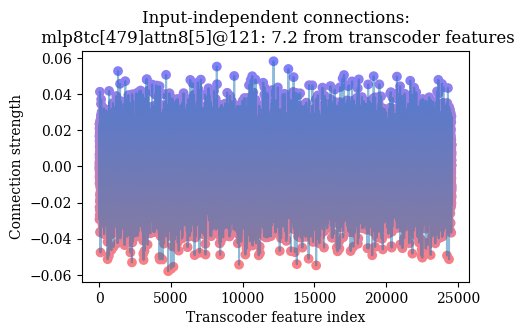

In [254]:
display_transcoder_pullback_features(model, all_paths[0][-1], transcoders[0])

In [255]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 12151, k=2)

In [258]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 8192, k=5)

In [257]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 13184, k=2)

In [259]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 1300, k=2)

First two transcoder features seem rather uninterpretable. But we see the `total` feature again, and feature `1300` has similar semantics.

### `attn8[7]@121 <- MLP0`

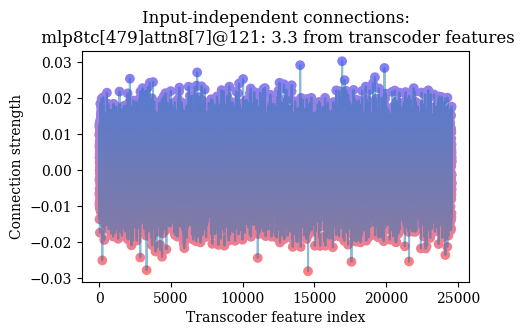

In [260]:
display_transcoder_pullback_features(model, all_paths[1][-1], transcoders[0])

In [261]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 16933, k=2)

In [262]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 14006, k=5)

In [263]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 19887, k=2)

In [264]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 6821, k=2)

... Huh. Now we're seeing ` population` and ` crowds`.

### `mlp4tc[18899]@121 <- MLP0`

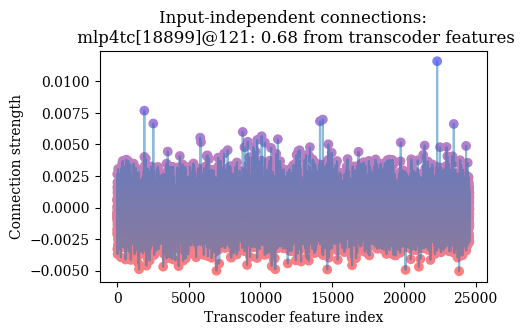

In [265]:
display_transcoder_pullback_features(model, all_paths[14][-1], transcoders[0])

In [266]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 22324, k=2)

Finally, something more sensible! Once again, previous token is probably ` estimated`.

### Final token

Let's look at `mlp7tc[13166]@-1`, which contributes from the current token.

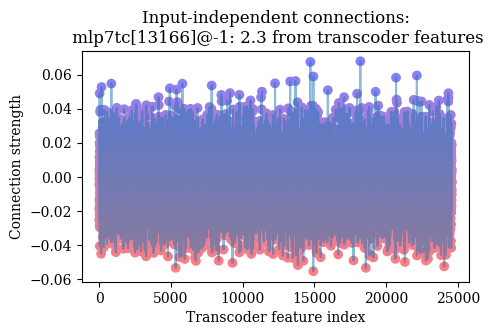

In [249]:
display_transcoder_pullback_features(model, all_paths[4][-1], transcoders[0])

In [250]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 18204, k=2)

In [251]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 14717, k=2)

Huh -- well this is a *discrepancy* from before!

In [267]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15, filter=FeatureFilter(token=-1))
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- mlp7tc[13166]@-1: 2.3
Path [1]: mlp8tc[479]@-1 <- mlp7tc[671]@-1: 2.2
Path [2]: mlp8tc[479]@-1 <- mlp7tc[4539]@-1: 1.6
Path [3]: mlp8tc[479]@-1 <- mlp6tc[2484]@-1: 1.5
Path [4]: mlp8tc[479]@-1 <- mlp7tc[22763]@-1: 0.93
Path [5]: mlp8tc[479]@-1 <- mlp6tc[21424]@-1: 0.92
Path [6]: mlp8tc[479]@-1 <- mlp6tc[15970]@-1: 0.89
Path [7]: mlp8tc[479]@-1 <- mlp7tc[22967]@-1: 0.87
Path [8]: mlp8tc[479]@-1 <- mlp6tc[15333]@-1: 0.8
Path [9]: mlp8tc[479]@-1 <- mlp3tc[22544]@-1: 0.73
Path [10]: mlp8tc[479]@-1 <- mlp5tc[18278]@-1: 0.72
Path [11]: mlp8tc[479]@-1 <- mlp5tc[11803]@-1: 0.7
Path [12]: mlp8tc[479]@-1 <- mlp7tc[21728]@-1: 0.64
Path [13]: mlp8tc[479]@-1 <- mlp7tc[13166]@-1: 2.3 <- mlp5tc[23882]@-1: 0.27
Path [14]: mlp8tc[479]@-1 <- mlp7tc[671]@-1: 2.2 <- mlp6tc[2484]@-1: 0.25
Path [15]: mlp8tc[479]@-1 <- mlp7tc[13166]@-1: 2.3 <- mlp5tc[23882]@-1: 0.27 <- mlp1tc[19616]@-1: 0.029


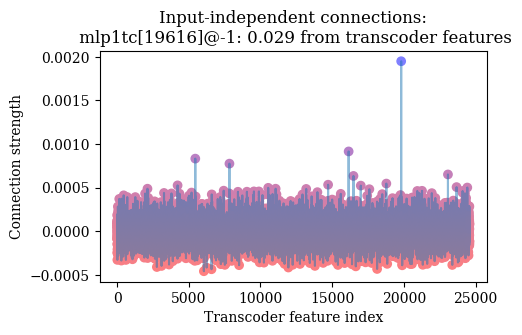

In [268]:
display_transcoder_pullback_features(model, all_paths[15][-1], transcoders[0])

In [270]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 19815, k=2)

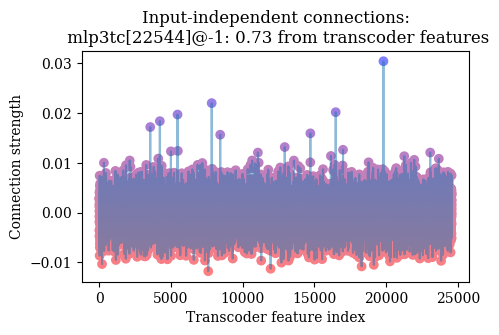

In [273]:
display_transcoder_pullback_features(model, all_paths[9][-1], transcoders[0])

In [274]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 19815, k=2)

Huh -- so final token is looking like "length". As such, this input seems to be "... estimated length"

### Earlier tokens

In [293]:
feature_idx = live_features[400]
my_feature = make_sae_feature_vector(transcoders[8], feature_idx, use_encoder=True, token=-1)
print(my_feature)

mlp8tc[479]@-1


In [294]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=20,
                                 filter=FeatureFilter(token=121, token_filter_type=FilterType.LT))
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- attn6[11]@120: 1.1
Path [1]: mlp8tc[479]@-1 <- attn8[5]@120: 1.1
Path [2]: mlp8tc[479]@-1 <- attn8[7]@120: 1.0
Path [3]: mlp8tc[479]@-1 <- attn7[0]@120: 0.96
Path [4]: mlp8tc[479]@-1 <- attn7[9]@120: 0.9
Path [5]: mlp8tc[479]@-1 <- attn4[0]@119: 0.75
Path [6]: mlp8tc[479]@-1 <- attn3[8]@119: 0.75
Path [7]: mlp8tc[479]@-1 <- attn7[0]@119: 0.62
Path [8]: mlp8tc[479]@-1 <- attn6[0]@119: 0.55
Path [9]: mlp8tc[479]@-1 <- attn4[1]@120: 0.54
Path [10]: mlp8tc[479]@-1 <- attn3[2]@120: 0.45
Path [11]: mlp8tc[479]@-1 <- attn8[4]@120: 0.45
Path [12]: mlp8tc[479]@-1 <- attn2[3]@120: 0.39
Path [13]: mlp8tc[479]@-1 <- attn2[0]@119: 0.36
Path [14]: mlp8tc[479]@-1 <- attn8[8]@120: 0.35
Path [15]: mlp8tc[479]@-1 <- attn1[0]@120: 0.32
Path [16]: mlp8tc[479]@-1 <- attn5[2]@120: 0.31
Path [17]: mlp8tc[479]@-1 <- attn2[5]@120: 0.31
Path [18]: mlp8tc[479]@-1 <- attn8[7]@119: 0.27
Path [19]: mlp8tc[479]@-1 <- attn6[0]@119: 0.55 <- mlp5tc[10350]@119: 0.2
Path [20]: mlp8tc[479]@-1 <

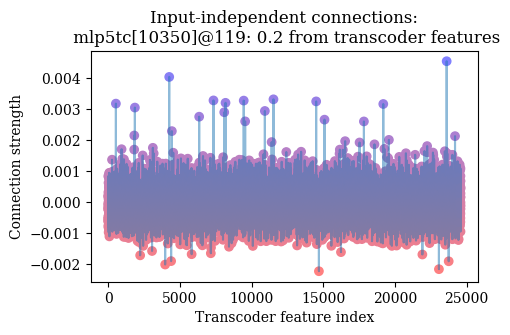

In [295]:
display_transcoder_pullback_features(model, all_paths[19][-1], transcoders[0])

In [298]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 23607, k=2)

In [297]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 4252, k=2)

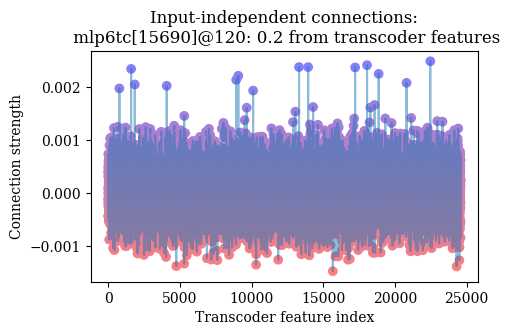

In [299]:
display_transcoder_pullback_features(model, all_paths[20][-1], transcoders[0])

In [300]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 22463, k=2)

In [301]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 18052, k=2)

"with an estimated length"

Now, let's look even further into the past.

In [302]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=20,
                                 filter=FeatureFilter(token=119, token_filter_type=FilterType.LT))
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- attn1[6]@30: 0.22
Path [1]: mlp8tc[479]@-1 <- attn7[8]@115: 0.16
Path [2]: mlp8tc[479]@-1 <- attn6[4]@115: 0.15
Path [3]: mlp8tc[479]@-1 <- attn3[5]@115: 0.11
Path [4]: mlp8tc[479]@-1 <- attn7[1]@81: 0.11
Path [5]: mlp8tc[479]@-1 <- attn4[2]@78: 0.11
Path [6]: mlp8tc[479]@-1 <- attn1[1]@118: 0.098
Path [7]: mlp8tc[479]@-1 <- attn1[6]@115: 0.094
Path [8]: mlp8tc[479]@-1 <- attn1[10]@6: 0.094
Path [9]: mlp8tc[479]@-1 <- attn6[7]@115: 0.089
Path [10]: mlp8tc[479]@-1 <- attn5[10]@29: 0.086
Path [11]: mlp8tc[479]@-1 <- attn5[9]@85: 0.072
Path [12]: mlp8tc[479]@-1 <- attn5[9]@85: 0.072 <- attn4[0]@83: 0.043
Path [13]: mlp8tc[479]@-1 <- attn5[9]@85: 0.072 <- attn2[8]@83: 0.042
Path [14]: mlp8tc[479]@-1 <- attn5[10]@29: 0.086 <- mlp4tc[23257]@29: 0.038
Path [15]: mlp8tc[479]@-1 <- attn5[10]@29: 0.086 <- attn1[11]@29: 0.036
Path [16]: mlp8tc[479]@-1 <- attn5[10]@29: 0.086 <- mlp4tc[6214]@29: 0.034
Path [17]: mlp8tc[479]@-1 <- attn5[10]@29: 0.086 <- mlp2tc[13133]@29: 

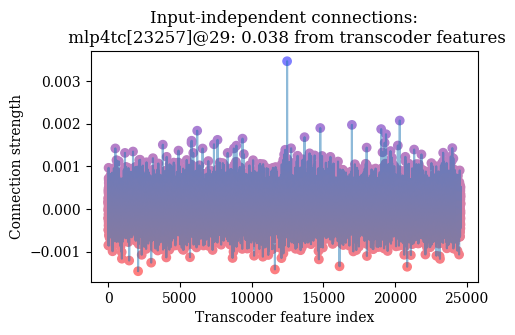

In [303]:
display_transcoder_pullback_features(model, all_paths[14][-1], transcoders[0])

In [304]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 12475, k=2)

In [318]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 16996, k=2)

We see some "remaining" and "remainder" stuff again -- but way in the past.

### Current hypothesis

**Current hypothesis:** I dunno, man. "Remainder" in context and "estimated" as previous (or antepenultimate) token?

## Input 7589, 89

In [324]:
prompt = owt_tokens_torch[7589, :89+1]
_, cache = model.run_with_cache(prompt)

In [325]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- attn8[5]@88: 4.4
Path [1]: mlp8tc[479]@-1 <- attn8[4]@87: 2.9
Path [2]: mlp8tc[479]@-1 <- attn8[5]@87: 2.5
Path [3]: mlp8tc[479]@-1 <- mlp3tc[23550]@89: 2.2
Path [4]: mlp8tc[479]@-1 <- attn6[11]@87: 2.1
Path [5]: mlp8tc[479]@-1 <- attn7[0]@87: 2.0
Path [6]: mlp8tc[479]@-1 <- mlp7tc[671]@89: 1.8
Path [7]: mlp8tc[479]@-1 <- attn3[11]@87: 1.8
Path [8]: mlp8tc[479]@-1 <- mlp2tc[5166]@89: 1.6
Path [9]: mlp8tc[479]@-1 <- attn7[9]@85: 1.3
Path [10]: mlp8tc[479]@-1 <- mlp6tc[2484]@89: 1.3
Path [11]: mlp8tc[479]@-1 <- attn7[4]@88: 1.2
Path [12]: mlp8tc[479]@-1 <- mlp7tc[14110]@89: 1.2
Path [13]: mlp8tc[479]@-1 <- attn8[4]@87: 2.9 <- mlp3tc[16179]@87: 0.51
Path [14]: mlp8tc[479]@-1 <- mlp2tc[5166]@89: 1.6 <- mlp1tc[12852]@89: 0.47
Path [15]: mlp8tc[479]@-1 <- attn3[11]@87: 1.8 <- mlp2tc[11150]@87: 0.42
Path [16]: mlp8tc[479]@-1 <- attn7[0]@87: 2.0 <- mlp6tc[20620]@87: 0.4


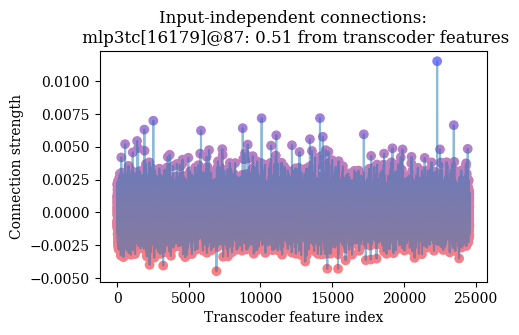

In [326]:
display_transcoder_pullback_features(model, all_paths[13][-1], transcoders[0])

In [266]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 22324, k=2)

Once again, "estimated" two tokens ago.

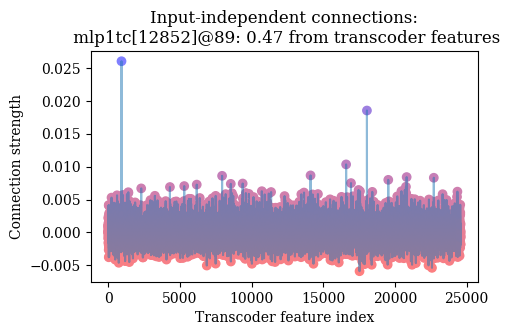

In [327]:
display_transcoder_pullback_features(model, all_paths[14][-1], transcoders[0])

In [328]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 923, k=2)

Now it's "estimated revenue"

In [329]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15,
                                filter=FeatureFilter(token=88))
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- attn8[5]@88: 4.4
Path [1]: mlp8tc[479]@-1 <- attn7[4]@88: 1.2
Path [2]: mlp8tc[479]@-1 <- attn7[8]@88: 1.1
Path [3]: mlp8tc[479]@-1 <- attn5[2]@88: 0.96
Path [4]: mlp8tc[479]@-1 <- attn4[11]@88: 0.95
Path [5]: mlp8tc[479]@-1 <- attn4[9]@88: 0.8
Path [6]: mlp8tc[479]@-1 <- attn3[6]@88: 0.66
Path [7]: mlp8tc[479]@-1 <- attn6[11]@88: 0.64
Path [8]: mlp8tc[479]@-1 <- attn8[4]@88: 0.58
Path [9]: mlp8tc[479]@-1 <- attn5[6]@88: 0.52
Path [10]: mlp8tc[479]@-1 <- attn8[7]@88: 0.51
Path [11]: mlp8tc[479]@-1 <- attn6[8]@88: 0.45
Path [12]: mlp8tc[479]@-1 <- attn3[7]@88: 0.27
Path [13]: mlp8tc[479]@-1 <- attn2[4]@88: 0.25
Path [14]: mlp8tc[479]@-1 <- attn3[11]@88: 0.23
Path [15]: mlp8tc[479]@-1 <- attn8[5]@88: 4.4 <- mlp7tc[14110]@88: 0.34
Path [16]: mlp8tc[479]@-1 <- attn8[5]@88: 4.4 <- mlp7tc[3164]@88: 0.23
Path [17]: mlp8tc[479]@-1 <- attn4[11]@88: 0.95 <- mlp1tc[14473]@88: 0.21
Path [18]: mlp8tc[479]@-1 <- attn8[5]@88: 4.4 <- mlp7tc[8696]@88: 0.2
Path [19]: mlp8tc[4

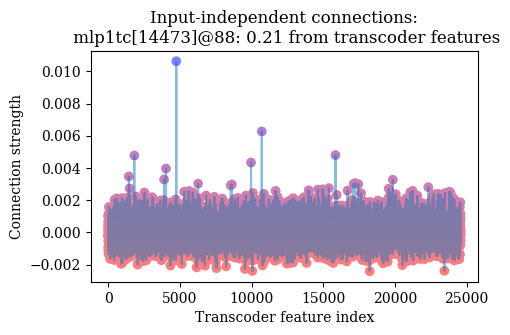

In [330]:
display_transcoder_pullback_features(model, all_paths[17][-1], transcoders[0])

In [331]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 4746, k=2)

### Earlier tokens

In [332]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15,
                                filter=FeatureFilter(token=87, token_filter_type=FilterType.LT))
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- attn7[9]@85: 1.3
Path [1]: mlp8tc[479]@-1 <- attn6[11]@86: 0.79
Path [2]: mlp8tc[479]@-1 <- attn3[2]@86: 0.63
Path [3]: mlp8tc[479]@-1 <- attn5[10]@71: 0.53
Path [4]: mlp8tc[479]@-1 <- attn4[1]@85: 0.52
Path [5]: mlp8tc[479]@-1 <- attn4[0]@85: 0.47
Path [6]: mlp8tc[479]@-1 <- attn3[8]@85: 0.42
Path [7]: mlp8tc[479]@-1 <- attn5[3]@85: 0.41
Path [8]: mlp8tc[479]@-1 <- attn5[10]@81: 0.37
Path [9]: mlp8tc[479]@-1 <- attn7[9]@86: 0.37
Path [10]: mlp8tc[479]@-1 <- attn5[3]@71: 0.36
Path [11]: mlp8tc[479]@-1 <- attn8[7]@86: 0.33
Path [12]: mlp8tc[479]@-1 <- attn8[4]@86: 0.32
Path [13]: mlp8tc[479]@-1 <- attn5[4]@86: 0.31
Path [14]: mlp8tc[479]@-1 <- attn4[1]@86: 0.31
Path [15]: mlp8tc[479]@-1 <- attn3[8]@85: 0.42 <- attn2[3]@83: 0.12
Path [16]: mlp8tc[479]@-1 <- attn7[9]@85: 1.3 <- mlp4tc[23699]@85: 0.11
Path [17]: mlp8tc[479]@-1 <- attn6[11]@86: 0.79 <- mlp5tc[6568]@86: 0.11
Path [18]: mlp8tc[479]@-1 <- attn7[9]@85: 1.3 <- attn4[3]@81: 0.11
Path [19]: mlp8tc[479]@

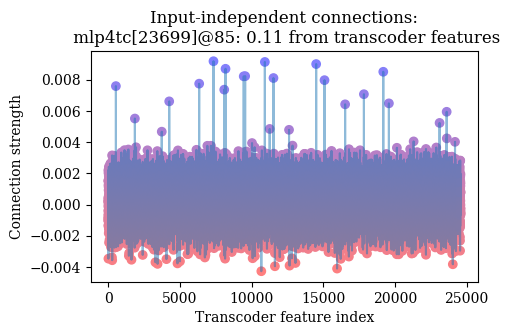

In [333]:
display_transcoder_pullback_features(model, all_paths[16][-1], transcoders[0])

In [335]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 10924, k=2)

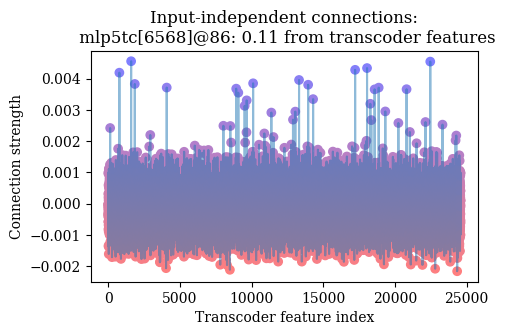

In [336]:
display_transcoder_pullback_features(model, all_paths[17][-1], transcoders[0])

In [337]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 1595, k=2)

Wait -- we've seen this before in the previous input! "with an estimated length" back then; now, it's "with an estimated annual revenue"

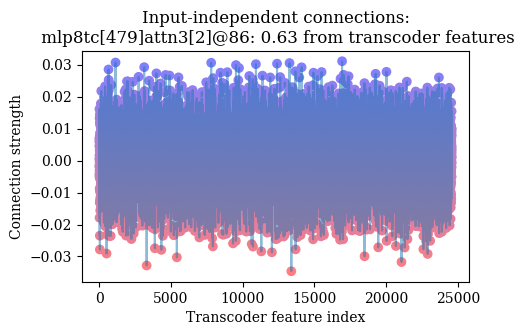

In [338]:
display_transcoder_pullback_features(model, all_paths[2][-1], transcoders[0])

Yep, most of these attention features tend to have uninterpretable pullbacks. So let's only look at transcoder features

In [341]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15,
                                filter=FeatureFilter(token=87, token_filter_type=FilterType.LT))
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(layer=0, layer_filter_type=FilterType.NE)])
all_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(feature_type=FeatureType.TRANSCODER)])
print_all_paths(all_paths)

Path [0]: mlp8tc[479]@-1 <- attn7[9]@85: 1.3 <- mlp4tc[23699]@85: 0.11
Path [1]: mlp8tc[479]@-1 <- attn6[11]@86: 0.79 <- mlp5tc[6568]@86: 0.11
Path [2]: mlp8tc[479]@-1 <- attn7[9]@85: 1.3 <- mlp4tc[23699]@85: 0.11 <- mlp1tc[22167]@85: 0.031


Oh, it's just the same one from before.

### Current hypothesis

**Current hypothesis:** feature fires on phrases like "with a total estimated ___"

## Moment of truth: confirming/denying our hypothesis

**Final hypothesis**: feature fires on phrases like "with a total estimated ___"

In [342]:
display_activating_examples_dash(owt_tokens_torch[:128*100], scores, window_size=7)

## Post-mortem

**How'd we do?** Nooooo -- it was a local context feature! I should've realized this from seeing how it was rarely the current token doing most of the heavy lifting.